The idea of that notebook is to have a reproducible benchmark working with the masters version of `pysap` and `modopt` in Jan 2023. The benchmark will be on speed, for both sparkling and uniform random acquisition schemes, with a brain phantom, for decimated wavelets.

In [1]:
%load_ext autoreload
%autoreload 2

# Third party import
import matplotlib.pyplot as plt
import numpy as np
# from scipy.ndimage import imread
# from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, gridded_inverse_fourier_transform_nd
from mri.operators import NonCartesianFFT, WaveletN
from mri.reconstructors import SingleChannelReconstructor
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity


/neurospin/optimed/KPooja/Environments/EPI_sparkling/lib/python3.8/site-packages/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "


#  Loading input data

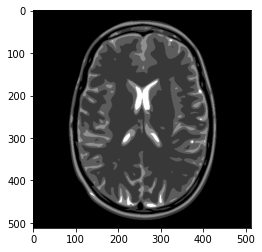

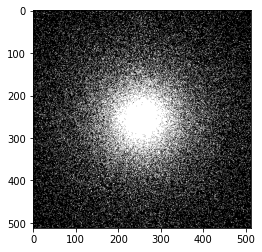

In [2]:
# Loading input data
image = get_sample_data("mri-slice-nifti")
plt.imshow(image, cmap='gray')

# original_image_data = np.copy(image.data)
# image.data += np.random.randn(*image.shape) * 20.
# image.data = image.data.astype(np.complex128)

# Loading input data
# image = get_sample_data('2d-mri')

# # Obtain MRI non-cartesian mask
# radial_mask = get_sample_data("mri-radial-samples")
# kspace_loc = radial_mask.data
# mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))

# Obtain MRI non-cartesian mask
mask = get_sample_data("mri-mask")
kspace_loc = convert_mask_to_locations(mask.data)
plt.figure()
plt.imshow(mask, cmap='gray')


# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [3]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape, implementation='gpuNUFFT')
kspace_obs = fourier_op.op(image.data)

Zero order solution

The Base SSIM is : 0.8206859502337546


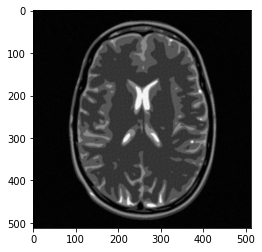

In [4]:
image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_obs))
plt.imshow(np.abs(image_rec0), cmap='gray')
base_ssim = ssim(image_rec0, image)
print('The Base SSIM is : ' + str(base_ssim))

# grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
# grid2D = np.meshgrid(grid_space, grid_space)
# grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
#                                                  tuple(grid2D), 'linear')
# image_rec0 = pysap.Image(data=grid_soln)
# base_ssim = ssim(image_rec0, image)
# print('The Base SSIM is : ' + str(base_ssim))

# FISTA optimization
We now want to refine the zero order solution using a FISTA optimization.

In [5]:
mu = 0.8

In [6]:
linear_op = WaveletN(wavelet_name='db4',
                         nb_scale=4,
                         dim=2,
                         padding='periodization')
regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=0,
)

In [7]:
def sparsity(x):
    return mu * np.sum(np.abs(x))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_obs)**2

def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def nrmse(x):
    return np.linalg.norm(x - image) / np.mean(image)    

In [8]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"z_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [9]:
opt_results = {}
max_iter = 1000

In [ ]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=max_iter,
    metrics=metrics_,
    metric_call_period=20,
)

The Base SSIM is : 0.9699761638559805


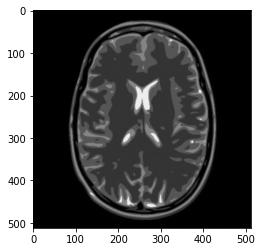

In [11]:
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(image_rec, cmap='gray')
base_ssim = ssim(image_rec, image)
print('The Base SSIM is : ' + str(base_ssim))

In [12]:
opt_results[mu] = {
        "cost": metrics['cost']['values'][-1],
        "nrmse": metrics['nrmse']['values'][-1],
    }
print(opt_results)

{0.8: {'cost': 174059874.22227478, 'nrmse': 68.0772826321373}}


In [ ]:
params = {
    r"FISTA-BT": ({}, "black"),
    r"FISTA-CD, $a = 20$": ({"a_cd": 20}, "blue"), 
    r"Rada-FISTA": (
    {"p_lazy": (1/30), "q_lazy": (1/20), "restart_strategy": "adaptive", "xi_restart": 0.96}, 
    "orange",
    ),
    r"greedy FISTA": (
    {"restart_strategy": "greedy", "xi_restart": 0.96, "s_greedy": 1.1}, 
    "violet",
    ),
}

res_param = {}
for param_name, (param, _) in (params.items()):
    x_final1, _, metrics = reconstructor.reconstruct(
        kspace_data=kspace_obs,
        optimization_alg='fista',
        num_iterations=300,
        metrics = metrics_,
        metric_call_period=1,
        **param,
    )

    image_rec = pysap.Image(data=np.abs(x_final1))
    plt.imshow(image_rec, cmap='gray')
    base_ssim = ssim(image_rec, image)
    print('The Base SSIM is : ' + str(base_ssim))
    
    res_param[param_name] = {
        "cost": np.array(metrics['cost']['values']),
        "nrmse": np.array(metrics['nrmse']['values']),
    }

Text(0, 0.5, '$\\log_{10}||\\phi(x_k) -\\phi(x*))||_2$')

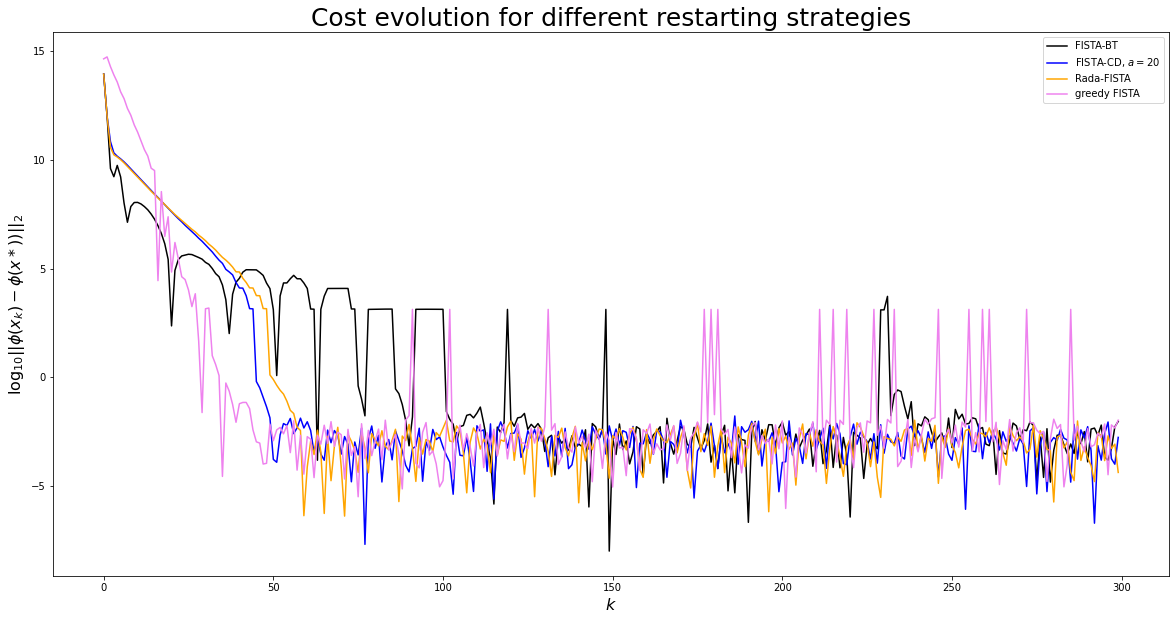

In [14]:
metric_name = "cost"
plt.figure(figsize=(20, 10))
for param_name, param_res in res_param.items():
    x = np.power(np.array(param_res[metric_name] - opt_results[mu][metric_name]), 2)
    plt.plot(
        np.log10(np.abs(x)), 
        label=param_name, 
        color=params[param_name][1],
    )
plt.legend()
plt.title("Cost evolution for different restarting strategies", size = 25)
plt.xlabel("$k$", size = 16)
plt.ylabel("$\log_{10}||\phi(x_k) -\phi(x*))||_2$", size = 16)